## Final Project Submission

Please fill out:
* Student name: Mindy Jen
* Student pace: full time, ds-ft-online-05262020
* Scheduled project review date/time: Sep. 24th, 2020/12:45-13:30 (CDT)
* Instructor name: Yish Lim
* Blog post URL: [Mod4_Blog](https://renjmindy.github.io/diagnosis_of_covid-19_alike_viral_pneumonia)
* fine data: [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
* full data: [Mendeley](https://data.mendeley.com/datasets/rscbjbr9sj/3)

In [1]:
import time
import datetime
from datetime import date
import os, shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import scipy
import numpy as np
import pandas as pd
from PIL import Image
from scipy import ndimage
from sklearn.preprocessing import LabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor

np.random.seed(123)
original_start = datetime.datetime.now()
start = datetime.datetime.now()

import warnings
warnings.filterwarnings('ignore')

In [2]:
new_dir = 'split/'

train_folder = os.path.join(new_dir, 'train')
train_pneumonia = os.path.join(train_folder, 'PNEUMONIA')
train_normal = os.path.join(train_folder, 'NORMAL')

test_folder = os.path.join(new_dir, 'test')
test_pneumonia = os.path.join(test_folder, 'PNEUMONIA')
test_normal = os.path.join(test_folder, 'NORMAL')

val_folder = os.path.join(new_dir, 'validation')
val_pneumonia = os.path.join(val_folder, 'PNEUMONIA')
val_normal = os.path.join(val_folder, 'NORMAL')

In [3]:
# get all the data in the directory split/train (3,418 images), and reshape them
print('training data:')
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    # This is the target directory
    train_folder, 
    # All images will be resized to 150x150
    target_size=(210, 210), batch_size = 4685)

training data:
Found 4685 images belonging to 2 classes.


In [4]:
# get all the data in the directory split/validation (427 images), and reshape them
print('validating data:')
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_folder, 
    target_size=(210, 210), batch_size = 585)

validating data:
Found 586 images belonging to 2 classes.


In [5]:
# get all the data in the directory split/test (427 images), and reshape them
print('testing data:')
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_folder, 
    target_size=(210, 210), batch_size = 585)

testing data:
Found 585 images belonging to 2 classes.


In [6]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [7]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [8]:
train_y = np.reshape(train_labels[:,0], (train_labels.shape[0],1))
test_y = np.reshape(test_labels[:,0], (test_labels.shape[0],1))
val_y = np.reshape(val_labels[:,0], (val_labels.shape[0],1))

In [9]:
# NORMAL
print(train_y[train_y==0].shape[0]/train_y.shape[0])
print(test_y[test_y==0].shape[0]/test_y.shape[0])
print(val_y[val_y==0].shape[0]/val_y.shape[0])

0.7295624332977588
0.7299145299145299
0.7299145299145299


In [10]:
# PNEUMONIA
print(train_y[train_y==1].shape[0]/train_y.shape[0])
print(test_y[test_y==1].shape[0]/test_y.shape[0])
print(val_y[val_y==1].shape[0]/val_y.shape[0])

0.27043756670224117
0.27008547008547007
0.27008547008547007


In [11]:
df_do = pd.read_csv('cnn1_chest_xray_ALL_data_5dropout2020-09-20_history.csv', index_col=None)
df_es = pd.read_csv('cnn1_chest_xray_ALL_data_BestModel2020-09-22_history.csv', index_col=None)
df_l1 = pd.read_csv('cnn1_chest_xray_ALL_data_L1reg2020-09-21_history.csv', index_col=None)
df_l2 = pd.read_csv('cnn1_chest_xray_ALL_data_L2reg2020-09-21_history.csv', index_col=None)

In [12]:
df_do.drop('Unnamed: 0',axis=1,inplace=True)
df_do.rename({'loss': 'loss_do', 'accuracy': 'accuracy_do', 'val_loss': 'val_loss_do', 'val_accuracy': 'val_accuracy_do'}, axis=1, inplace=True)
df_do.head()

,loss_do,accuracy_do,val_loss_do,val_accuracy_do
0,0.546556,0.732978,0.556808,0.788034
1,0.445432,0.795091,0.504890,0.866667
2,0.372252,0.844824,0.419671,0.885470
3,0.326072,0.867876,0.427799,0.851282
4,0.302677,0.875774,0.299740,0.895727


In [13]:
df_do.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   loss_do          40 non-null     float64
 1   accuracy_do      40 non-null     float64
 2   val_loss_do      40 non-null     float64
 3   val_accuracy_do  40 non-null     float64
dtypes: float64(4)
memory usage: 1.4 KB


In [14]:
df_es.drop('Unnamed: 0',axis=1,inplace=True)
df_es.rename({'loss': 'loss_es', 'accuracy': 'accuracy_es', 'val_loss': 'val_loss_es', 'val_accuracy': 'val_accuracy_es'}, axis=1, inplace=True)
df_es.head()

,loss_es,accuracy_es,val_loss_es,val_accuracy_es
0,0.563634,0.729989,0.523944,0.729915
1,0.460486,0.779723,0.400342,0.798291
2,0.362692,0.855069,0.318989,0.902564
3,0.303212,0.879829,0.289770,0.876923
4,0.269860,0.895197,0.259839,0.909402


In [15]:
df_es.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   loss_es          64 non-null     float64
 1   accuracy_es      64 non-null     float64
 2   val_loss_es      64 non-null     float64
 3   val_accuracy_es  64 non-null     float64
dtypes: float64(4)
memory usage: 2.1 KB


In [16]:
df_es.index

RangeIndex(start=0, stop=64, step=1)

In [17]:
df_es_unwanted = df_es[(df_es.index>39) & (df_es.index<64)]
print(df_es_unwanted.head())
df_es.drop(df_es_unwanted.index, axis=0, inplace=True)
df_es.info()

     loss_es  accuracy_es  val_loss_es  val_accuracy_es
40  0.098092     0.964141     0.154043         0.941880
41  0.097238     0.965208     0.150849         0.941880
42  0.095053     0.964354     0.150815         0.940171
43  0.097466     0.964568     0.159079         0.933333
44  0.092421     0.965422     0.166798         0.935043
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 0 to 39
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   loss_es          40 non-null     float64
 1   accuracy_es      40 non-null     float64
 2   val_loss_es      40 non-null     float64
 3   val_accuracy_es  40 non-null     float64
dtypes: float64(4)
memory usage: 1.6 KB


In [18]:
df_l1.drop('Unnamed: 0',axis=1,inplace=True)
df_l1.rename({'loss': 'loss_l1', 'accuracy': 'accuracy_l1', 'val_loss': 'val_loss_l1', 'val_accuracy': 'val_accuracy_l1'}, axis=1, inplace=True)
df_l1.head()

,loss_l1,accuracy_l1,val_loss_l1,val_accuracy_l1
0,0.569182,0.720598,0.525843,0.738462
1,0.472705,0.766916,0.415256,0.800000
2,0.383103,0.846745,0.357732,0.830769
3,0.319155,0.885165,0.310009,0.878632
4,0.284274,0.892423,0.330075,0.876923


In [19]:
df_l1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   loss_l1          40 non-null     float64
 1   accuracy_l1      40 non-null     float64
 2   val_loss_l1      40 non-null     float64
 3   val_accuracy_l1  40 non-null     float64
dtypes: float64(4)
memory usage: 1.4 KB


In [20]:
df_l2.drop('Unnamed: 0',axis=1,inplace=True)
df_l2.rename({'loss': 'loss_l2', 'accuracy': 'accuracy_l2', 'val_loss': 'val_loss_l2', 'val_accuracy': 'val_accuracy_l2'}, axis=1, inplace=True)
df_l2.head()

,loss_l2,accuracy_l2,val_loss_l2,val_accuracy_l2
0,0.569298,0.728495,0.519226,0.729915
1,0.474923,0.764354,0.417147,0.796581
2,0.384508,0.841195,0.339356,0.885470
3,0.324723,0.878549,0.357970,0.871795
4,0.284985,0.891782,0.287310,0.883761


In [21]:
df_l2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   loss_l2          40 non-null     float64
 1   accuracy_l2      40 non-null     float64
 2   val_loss_l2      40 non-null     float64
 3   val_accuracy_l2  40 non-null     float64
dtypes: float64(4)
memory usage: 1.4 KB


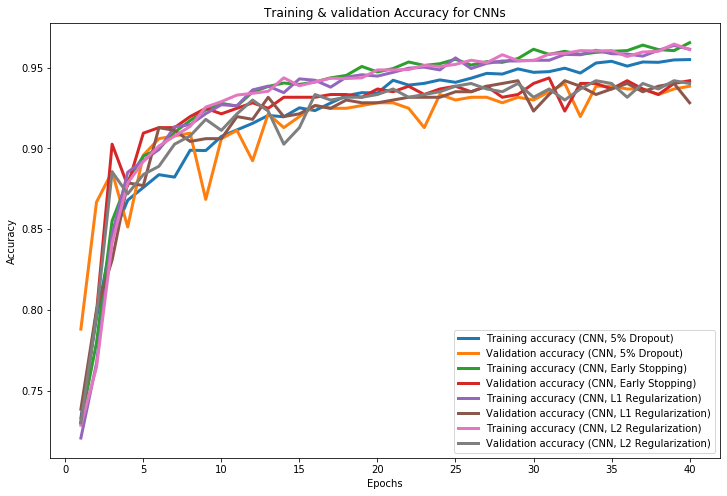

In [22]:
# CNN model details
do = df_do['accuracy_do'] 
do_val = df_do['val_accuracy_do']
es = df_es['accuracy_es'] 
es_val = df_es['val_accuracy_es']
l1 = df_l1['accuracy_l1'] 
l1_val = df_l1['val_accuracy_l1']
l2 = df_l2['accuracy_l2'] 
l2_val = df_l2['val_accuracy_l2']

# Plot the accuracy for these models
fig, ax = plt.subplots(figsize=(12, 8))
epochs = range(1, len(do) + 1)
ax.plot(epochs, do, label='Training accuracy (CNN, 5% Dropout)', linewidth=3.0)
ax.plot(epochs, do_val, label='Validation accuracy (CNN, 5% Dropout)', linewidth=3.0)
ax.plot(epochs, es, label='Training accuracy (CNN, Early Stopping)', linewidth=3.0)
ax.plot(epochs, es_val, label='Validation accuracy (CNN, Early Stopping)', linewidth=3.0)
ax.plot(epochs, l1, label='Training accuracy (CNN, L1 Regularization)', linewidth=3.0)
ax.plot(epochs, l1_val, label='Validation accuracy (CNN, L1 Regularization)', linewidth=3.0)
ax.plot(epochs, l2, label='Training accuracy (CNN, L2 Regularization)', linewidth=3.0)
ax.plot(epochs, l2_val, label='Validation accuracy (CNN, L2 Regularization)', linewidth=3.0)
ax.set_title('Training & validation Accuracy for CNNs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend();

fig.savefig('CNN_accuracy_summary.png')

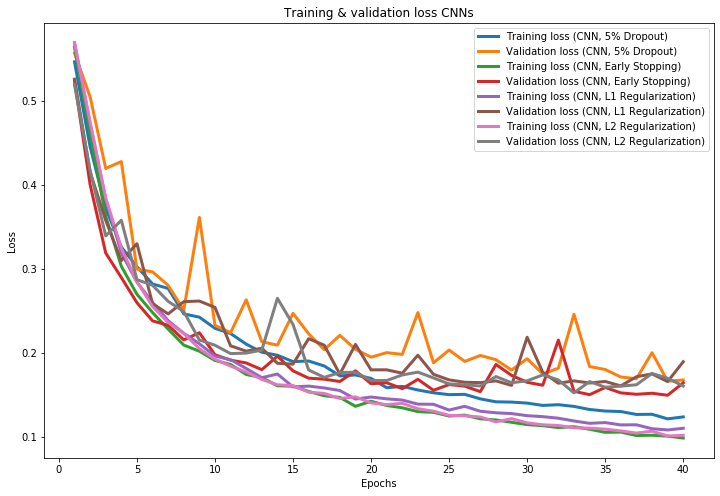

In [23]:
# CNN model details
do = df_do['loss_do'] 
do_val = df_do['val_loss_do']
es = df_es['loss_es'] 
es_val = df_es['val_loss_es']
l1 = df_l1['loss_l1'] 
l1_val = df_l1['val_loss_l1']
l2 = df_l2['loss_l2'] 
l2_val = df_l2['val_loss_l2']

# Plot the accuracy for these models
fig, ax = plt.subplots(figsize=(12, 8))
epochs = range(1, len(do) + 1)
ax.plot(epochs, do, label='Training loss (CNN, 5% Dropout)', linewidth=3.0)
ax.plot(epochs, do_val, label='Validation loss (CNN, 5% Dropout)', linewidth=3.0)
ax.plot(epochs, es, label='Training loss (CNN, Early Stopping)', linewidth=3.0)
ax.plot(epochs, es_val, label='Validation loss (CNN, Early Stopping)', linewidth=3.0)
ax.plot(epochs, l1, label='Training loss (CNN, L1 Regularization)', linewidth=3.0)
ax.plot(epochs, l1_val, label='Validation loss (CNN, L1 Regularization)', linewidth=3.0)
ax.plot(epochs, l2, label='Training loss (CNN, L2 Regularization)', linewidth=3.0)
ax.plot(epochs, l2_val, label='Validation loss (CNN, L2 Regularization)', linewidth=3.0)
ax.set_title('Training & validation loss CNNs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

fig.savefig('CNN_loss_summary.png')